In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

<h3>TDSE Forward Problem</h3>

In [2]:
# set radius of spatial domain
L = 16

# set real space grid, used for plotting
nx = 1025
# dx is needed to perform norm check of training data
xvec, dx = np.linspace(-L, L, nx, retstep=True)

# set number of Fourier basis
nF = 128
# matrix for converting Fourier basis coefficients to real space values
nvec = np.arange(-nF, nF + 1) # nvec=-nfb,...,0,...,nfb
FtoRmat = (1 / np.sqrt(2 * L)) * np.exp(1j * np.pi * np.outer(nvec, xvec) / L)

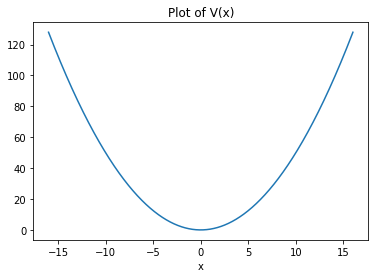

In [5]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential
Vxvec = v(xvec)

# plot true potential
plt.plot(xvec, Vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [14]:
# this code transforms the true potential to the
# Fourier basis

# Fres is used to adjust the Fourier basis resolution
# if Fres = 1, then Fsample = 2*nfb, which is the
# Nyquist frequency (most course resolution?)
Fres = 100
Fsample = Fres * 2 * nF
Fxvec = np.linspace(-L, L, Fsample + 2, endpoint=False)
Fvvec = (np.fft.rfft(v(Fxvec)) / Fxvec.size)[:(2 * nF + 1)]

(257,)
(257, 1025)


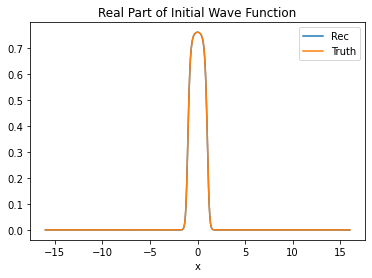

Rel Norm Diff: 5.020489938219892e-05


In [15]:
# define initial state and transform to Fourier basis

# I GET BETTER RESULTS WHEN I USE MY METHOD WHICH NORMALIZES
# THE INITIAL WAVE FUNCTION RATHER THAN USING THE WAVE FUNCTION
# NORMALIZED MANUALLY

def psi0(x):
    # rounded box function
    # return 1.0 + np.tanh((1 - x**2)/0.5)
    # HSB's manually normalized rounded box function
    return (1.0 + np.tanh((1 - x**2)/0.5)) / 2.58046
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))

# function for normalizing psi0
# uncomment when not using Harish's psi0
# def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    # psiprobintegrand = lambda x: np.abs(psifn(x))**2
    # normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    # def normpsifn(x):
    #     return psifn(x)/normterm

    # return normpsifn

# normpsi0fn = mknormpsifn(psi0)  # when not using Harish's psi0
normpsi0fn = psi0  # when using Harish's psi0
# vector of the normalized psi0 function sampled on the
# real space grid for plotting
normpsi0vec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
normpsi0integrand = lambda x: np.exp(-1j * np.pi * nvec * x / L) / np.sqrt(2 * L) * normpsi0fn(x)
normpsi0quadrtn = si.quad_vec(normpsi0integrand, -L, L)[0]
Fnormpsi0vec = si.quad_vec(normpsi0integrand, -L, L)[0]
print(normpsi0quadrtn.shape)
print(FtoRmat.shape)
# Fnormpsi0vecrec2 = normpsi0quadrtn @ Fmat
Fnormpsi0vecrec = normpsi0quadrtn @ FtoRmat

# plot the real part of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, label="Rec")
plt.plot(xvec, normpsi0vec.real, label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff:', nl.norm(normpsi0vec - Fnormpsi0vecrec) / nl.norm(normpsi0vec))

In [16]:
# to make a toeplitz matrix by hand (which is also
# JAX grad/jacobian compliant) we use NumPy/JAX's
# advance indexing functionality
# first make a vector indexing matrix which is used
# to construct the toeplitz matrix:
# toepindx = ((-1) * np.arange(0, ntoepelm)).reshape(ntoepelm, 1) + [np.arange(ntoepelm  -1, 2 * ntoepelm - 1)]
# then make a vector which is used to form the
# toeplitz matrix like:
# toepvec = np.concatenate([np.flipud(toeprow.conj()), toeprow[1:]])
# finally make the toeplitz matrix:
# toepmat = toeprepvec[toepindx]
ntoeelms = 2 * nF + 1
toeindx = ((-1) * np.arange(0, ntoeelms)).reshape(ntoeelms, 1) + [np.arange(ntoeelms  -1, 2 * ntoeelms - 1)]

In [17]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * L**2))

# store the Fourier series coefficients for n-m=0 to n-m=2*nmax
# as a vector can can be used to construct a toeplitz matrix
Fvtoerow = Fvvec * (-1)**np.arange(ntoeelms)
Fvtoevec = np.concatenate([np.flipud(Fvtoerow.conj()), Fvtoerow[1:]])
# make potential matrix from Fvtoevec
Fvmat = Fvtoevec[toeindx]

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.conj().T - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
5.72003711317733e-12
Unitary stts check (should be close to zero):
4.07668687362199e-14


In [18]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

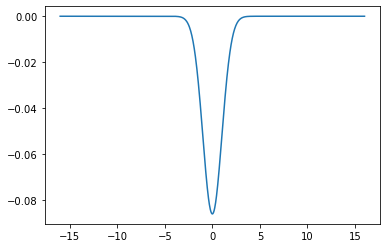

Quick check of Ground state' normalization (should be close to 1):
1.0000000000000018
Check of Ground state' normalization (should be close to 1):
1.0000000000000018


In [19]:
# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ FtoRmat
plt.plot(xvec, -np.real(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

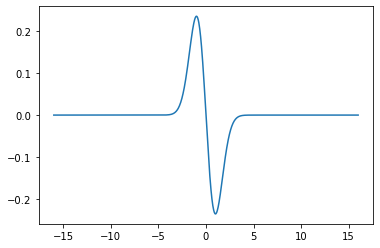

Quick check of Ground state' normalization (should be close to 1):
0.9999999999999993
Check of Ground state' normalization (should be close to 1):
0.9999999999999992


In [20]:
# pick out and plot the j-th state with j starting at 0
wavefn = Fstts[:,ordering[1]] @ FtoRmat
plt.plot(xvec, np.imag(wavefn))
plt.show()

# quick and dirty check if the ground state wave function
# is normalized
print('Quick check of Ground state\' normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of Ground state\' normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

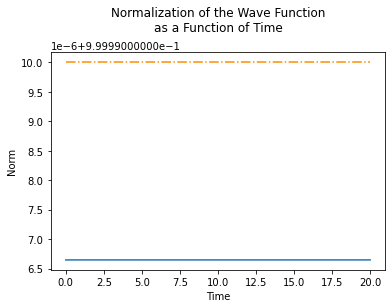

Average Norm of Trajectory (should be close to 1):
0.9999966470068131


In [21]:
# solve the forward problem and generate amat
# set the time step and compute the propagator matrix
# note that we are reusing the spectrum and states from
# the eigendecomposition of Hamiltonian matrix computed above

# set the size of a time step
dt = 0.01

# make the propagator matrix
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
nts = 2000

# propagate the system starting from the initial "a" state
Famat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
Famat[0,:] = Fnormpsi0vec.copy()
for i in range(nts):
    Famat[i + 1,:] = Fpropa @ Famat[i,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(Famat @ FtoRmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')